## EE 207 Project

Robert Summers

Anthony Van

Notes: Loaded in assets and set up general scheme for simplicity

In [17]:
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
import scipy.io.wavfile as wav
import scipy.signal as sig
from numpy.linalg import svd, norm, pinv
import nengo
from numpy import pi
from nengo.utils.ensemble import tuning_curves
rom numpy.lib import stride_tricks
%matplotlib inline

SyntaxError: invalid syntax (<ipython-input-17-8d41a68cd500>, line 11)

In [18]:
def stft(sig, frameSize, overlapFac=0.5, window=np.hanning):
    win = window(frameSize)
    hopSize = int(frameSize - np.floor(overlapFac * frameSize))
    
    # zeros at beginning (thus center of 1st window should be for sample nr. 0)
    samples = np.append(np.zeros(np.floor(frameSize/2.0)), sig)    
    # cols for windowing
    cols = np.ceil( (len(samples) - frameSize) / float(hopSize)) + 1
    # zeros at end (thus samples can be fully covered by frames)
    samples = np.append(samples, np.zeros(frameSize))
    
    frames = stride_tricks.as_strided(samples, shape=(cols, frameSize), strides=(samples.strides[0]*hopSize, samples.strides[0])).copy()
    frames *= win
    
    return np.fft.rfft(frames)    
    
""" scale frequency axis logarithmically """    
def logscale_spec(spec, sr=44100, factor=20.):
    timebins, freqbins = np.shape(spec)

    scale = np.linspace(0, 1, freqbins) ** factor
    scale *= (freqbins-1)/max(scale)
    scale = np.unique(np.round(scale))
    
    # create spectrogram with new freq bins
    newspec = np.complex128(np.zeros([timebins, len(scale)]))
    for i in range(0, len(scale)):
        if i == len(scale)-1:
            newspec[:,i] = np.sum(spec[:,scale[i]:], axis=1)
        else:        
            newspec[:,i] = np.sum(spec[:,scale[i]:scale[i+1]], axis=1)
    
    # list center freq of bins
    allfreqs = np.abs(np.fft.fftfreq(freqbins*2, 1./sr)[:freqbins+1])
    freqs = []
    for i in range(0, len(scale)):
        if i == len(scale)-1:
            freqs += [np.mean(allfreqs[scale[i]:])]
        else:
            freqs += [np.mean(allfreqs[scale[i]:scale[i+1]])]
    
    return newspec, freqs

""" plot spectrogram"""
def plotstft(audiopath, binsize=2**10, plotpath=None, colormap="jet"):
    samplerate, samples = wav.read(audiopath)
    s = stft(samples, binsize)
    
    sshow, freq = logscale_spec(s, factor=1.0, sr=samplerate)
    ims = 20.*np.log10(np.abs(sshow)/10e-6) # amplitude to decibel
    
    timebins, freqbins = np.shape(ims)
    
    plt.figure(figsize=(15, 7.5))
    plt.imshow(np.transpose(ims), origin="lower", aspect="auto", cmap=colormap, interpolation="none")
    plt.colorbar()

    plt.xlabel("time (s)")
    plt.ylabel("frequency (hz)")
    plt.xlim([0, timebins-1])
    plt.ylim([0, freqbins])

    xlocs = np.float32(np.linspace(0, timebins-1, 5))
    plt.xticks(xlocs, ["%.02f" % l for l in ((xlocs*len(samples)/timebins)+(0.5*binsize))/samplerate])
    ylocs = np.int16(np.round(np.linspace(0, freqbins-1, 10)))
    plt.yticks(ylocs, ["%.02f" % freq[i] for i in ylocs])
    
    if plotpath:
        plt.savefig(plotpath, bbox_inches="tight")
    else:
        plt.show()
        
    plt.clf()

plotstft("ba_1.wav")

C:\Users\Vancat and Robdog\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


NameError: global name 'stride_tricks' is not defined

269.606552374


ValueError: noverlap must be less than nperseg.

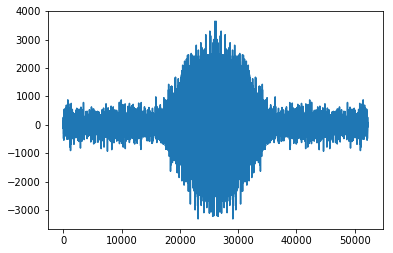

In [19]:
#Initialize Data
#testcomment

rate_ba, data_ba = wavi.read('ba_1.wav',mmap=False)
#tfreq = 1/rate*np.ones((data_ba.shape[0],1))
spec1 = np.real(np.fft.fft2(data_ba))
plt.plot(spec1[:,1])
print(np.mean(np.sqrt(spec1[:,1]**2)))
fre, te, Sxx = sig.spectrogram(data_ba, 5)

num_items = 2

d_key = 4
d_value = 4

rng = np.random.RandomState(seed=7)
keys = nengo.dists.UniformHypersphere(surface=True).sample(
    num_items, d_key, rng=rng)
print(keys)
values = nengo.dists.UniformHypersphere(surface=False).sample(
    num_items, d_value, rng=rng)

In [ ]:
#General Use Functions
intercept = (np.dot(keys, keys.T) - np.eye(num_items)).flatten().max()
print("Intercept: %s" % intercept)

In [ ]:
def cycle_array(x, period, dt=0.001):
    """Cycles through the elements"""
    i_every = int(round(period / dt))
    if i_every != period / dt:
        raise ValueError("dt (%s) does not divide period (%s)" % (dt, period))

    def f(t):
        i = int(round((t - dt) / dt))  # t starts at dt
        return x[int(i / i_every) % len(x)]

    return f

In [ ]:
# Model constants
n_neurons = 50
dt = 0.001
period = 0.9
T = period * num_items * 2

# Model network
model = nengo.Network()
with model:

    # Create the inputs/outputs
    stim_keys = nengo.Node(output=cycle_array(keys, period, dt))
    stim_values = nengo.Node(output=cycle_array(values, period, dt))
    learning = nengo.Node(output=lambda t: -int(t >= T / 2))
    recall = nengo.Node(size_in=d_value)

    # Create the memory
    memory = nengo.Ensemble(
        n_neurons, d_key, intercepts=[intercept] * n_neurons)

    # Learn the encoders/keys
    voja = nengo.Voja(post_tau=None, learning_rate=5e-1)
    conn_in = nengo.Connection(
        stim_keys, memory, synapse=None, learning_rule_type=voja)
    nengo.Connection(learning, conn_in.learning_rule, synapse=None)

    # Learn the decoders/values, initialized to a null function
    conn_out = nengo.Connection(
        memory,
        recall,
        learning_rule_type=nengo.PES(1e-3),
        function=lambda x: np.zeros(d_value))

    # Create the error population
    error = nengo.Ensemble(n_neurons, d_value)
    nengo.Connection(
        learning, error.neurons, transform=[[10.0]] * n_neurons, synapse=None)

    # Calculate the error and use it to drive the PES rule
    nengo.Connection(stim_values, error, transform=-1, synapse=None)
    nengo.Connection(recall, error, synapse=None)
    nengo.Connection(error, conn_out.learning_rule)

    # Setup probes
    p_keys = nengo.Probe(stim_keys, synapse=None)
    p_values = nengo.Probe(stim_values, synapse=None)
    p_learning = nengo.Probe(learning, synapse=None)
    p_error = nengo.Probe(error, synapse=0.005)
    p_recall = nengo.Probe(recall, synapse=None)
    p_encoders = nengo.Probe(conn_in.learning_rule, 'scaled_encoders')

In [ ]:
with nengo.Simulator(model, dt=dt) as sim:
    sim.run(T)
t = sim.trange()

plt.figure()
plt.title("Keys")
plt.plot(t, sim.data[p_keys])
plt.ylim(-1, 1)

plt.figure()
plt.title("Values")
plt.plot(t, sim.data[p_values])
plt.ylim(-1, 1)

plt.figure()
plt.title("Learning")
plt.plot(t, sim.data[p_learning])
plt.ylim(-1.2, 0.2);

In [ ]:
train = t <= T / 2
test = ~train

plt.figure()
plt.title("Value Error During Training")
plt.plot(t[train], sim.data[p_error][train])

plt.figure()
plt.title("Value Error During Recall")
plt.plot(t[test], sim.data[p_recall][test] - sim.data[p_values][test]);

In [ ]:

scale = (sim.data[memory].gain / memory.radius)[:, np.newaxis]




def plot_2d(text, xy):
    plt.figure()
    plt.title(text)
    plt.scatter(xy[:, 0], xy[:, 1], label="Encoders")
    plt.scatter(
        keys[:, 0], keys[:, 1], c='red', s=150, alpha=0.6, label="Keys")
    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 2)
    plt.legend()
    plt.axes().set_aspect('equal')


plot_2d("Before", sim.data[p_encoders][0].copy() / scale)
plot_2d("After", sim.data[p_encoders][-1].copy() / scale)